In [1]:
%load_ext autoreload
%autoreload 2

# Portein
## Portraits of Proteins

Portein plots 3D proteins according to their best 2D projection (best = greatest area visible), allowing for easy automation of protein visualization.

In [2]:
import prody as pd
import portein
import matplotlib.pyplot as plt
import numpy as np
import yaml
import warnings
warnings.filterwarnings('ignore')
portein.compile_numba_functions()

## Orient your protein

Portein uses some linear algebra (for [Optimal rotation of 3D model for 2D projection](https://stackoverflow.com/a/2970340) and [Rotating an object to maximize bounding box height](https://stackoverflow.com/a/47844156)) to find the best 2D projection for the input protein's 3D coordinates. 

**Example orientation:**

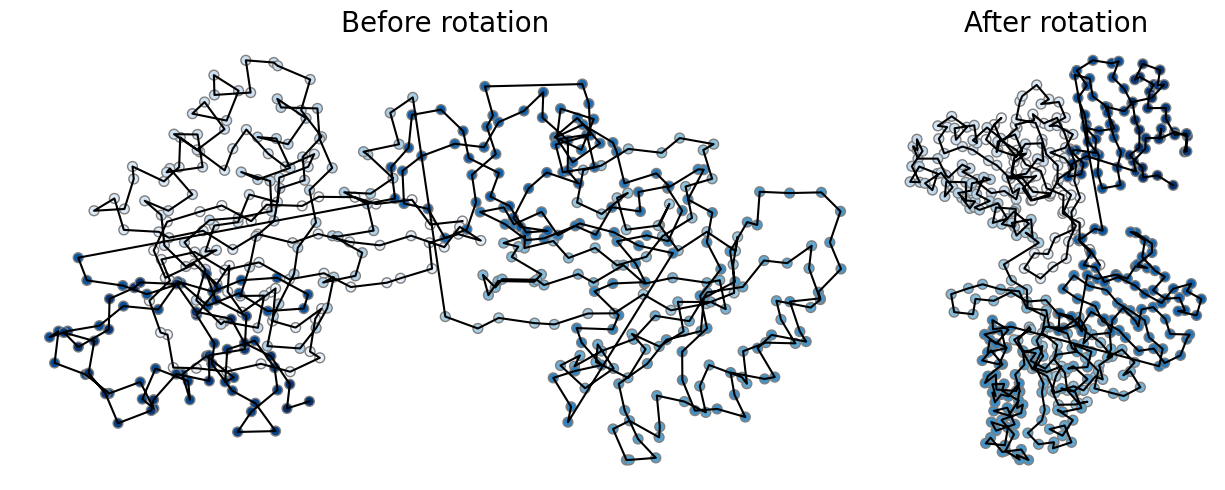

In [3]:
pdb = pd.parsePDB("7lc2")
old_coords = pdb.select("protein and calpha").getCoords()

# Rotate the protein
pdb_oriented = portein.rotate_protein(pdb)
pd.writePDB("images/7lc2_rotated.pdb", pdb_oriented)
new_coords = pdb_oriented.select("protein and calpha").getCoords()

# Find the best size of the plot based on the coordinates and a given height (or width)
old_width, old_height = portein.find_size(old_coords, height=5)
new_width, new_height = portein.find_size(new_coords, height=5)

fig, ax = plt.subplots(1, 2, figsize=(old_width + new_width, new_height), gridspec_kw={"width_ratios": [old_width, new_width]})
ax[0].plot(old_coords[:, 0], old_coords[:, 1], "-", c="black")
ax[0].scatter(old_coords[:, 0], old_coords[:, 1], c=np.arange(old_coords.shape[0]), s=50, cmap="Blues", edgecolors="gray")
ax[1].plot(new_coords[:, 0], new_coords[:, 1], "-", c="black")
ax[1].scatter(new_coords[:, 0], new_coords[:, 1], c=np.arange(new_coords.shape[0]), s=50, cmap="Blues", edgecolors="gray")
ax[0].set_title("Before rotation", fontsize=20)
ax[1].set_title("After rotation", fontsize=20)
ax[0].axis("off")
ax[1].axis("off")
plt.tight_layout()

## Plot Pymol ray-traced images

Requires: [pymol](https://github.com/schrodinger/pymol-open-source)

Automatically layer different Pymol representations on top of each other, each one ray-traced separately and then combined with user-defined transparencies. All variables that can be set in Pymol can be passed to the `PymolConfig` object.

In [4]:
# Using some default nice PyMOL settings
with open("configs/pymol_settings.yaml") as f:
    pymol_settings = yaml.safe_load(f)
pymol_settings

{'ambient': 0.5,
 'antialias': 2,
 'cartoon_discrete_colors': True,
 'cartoon_fancy_helices': True,
 'cartoon_sampling': 20,
 'depth_cue': False,
 'hash_max': 300,
 'light_count': 1,
 'ray_opaque_background': False,
 'ray_shadows': False,
 'ray_texture': 0,
 'ray_trace_disco_factor': 1,
 'ray_trace_fog': False,
 'ray_trace_gain': 0,
 'ray_trace_mode': 1,
 'specular': False,
 'surface_quality': 2}

In [5]:
# Rotate the protein, set the width of the plot (height is auto-calculated), and the colormap for the chains (can also be a dictionary of chain: color)
protein_config = portein.ProteinConfig(pdb_file="7lc2", rotate=True, width=1000, chain_colormap="Set3", output_prefix="images/7lc2")

# Single layer of cartoon representation
pymol_config = portein.PymolConfig(layers=[portein.PymolRepresentationConfig(representation="cartoon",
                                                                             pymol_settings=pymol_settings)])

# Run PyMOL
pymol_class = portein.Pymol(protein_config=protein_config, pymol_config=pymol_config)
image_file = pymol_class.run()

 Ray: render time: 6.08 sec. = 591.6 frames/hour (11.74 sec. accum.).


![Simple Pymol example](images/7lc2_rotated_pymol.png)

Here's a fancier version with three layers:
- Layer 1 is surface at 0.5 opacity
- Layer 2 is cartoon
- Layer 3 has only some residues displayed as sticks, set by the `selection="highlight"` in `PymolRepresentationConfig` and `highlight_residues` in `ProteinConfig`. 

The `selection` attribute can also be any kind of Pymol selection ("all" by default)

In [6]:

protein_config = portein.ProteinConfig(pdb_file="7lc2", rotate=True, output_prefix="images/7lc2_fancy",
                                       chain_colormap="Set3", 
                                       highlight_residues={"A": {"black": [30, 35], "red": list(range(10,20))},
                                                           "B": {"black": [25], "red": list(range(10, 16))}},
                                       width=1000)
pymol_config = portein.PymolConfig(layers=[portein.PymolRepresentationConfig(representation="surface",
                                                                             pymol_settings=pymol_settings,
                                                                             transparency=0.5),
                                            portein.PymolRepresentationConfig(representation="cartoon",
                                                                                pymol_settings=pymol_settings),
                                            portein.PymolRepresentationConfig(representation="sticks",
                                                                                pymol_settings=pymol_settings,
                                                                                selection="highlight"),
                                                                        ],
                                    buffer=10)
pymol_class = portein.Pymol(protein_config=protein_config, pymol_config=pymol_config)
image_file = pymol_class.run()

 Ray: render time: 15.71 sec. = 229.1 frames/hour (79.32 sec. accum.).
 Ray: render time: 4.37 sec. = 823.4 frames/hour (88.30 sec. accum.).
 Ray: render time: 0.45 sec. = 8011.9 frames/hour (89.20 sec. accum.).


![Fancy Pymol example](images/7lc2_fancy_rotated_pymol.png)

## Plot `illustrate` images

Requires: [`illustrate`](https://github.com/ccsb-scripps/Illustrate), [`convert`](https://imagemagick.org/script/convert.php)

Uses David Goodsell's [`illustrate`](https://github.com/ccsb-scripps/Illustrate) to generate images. All `illustrate` parameters are user-definable.

In [7]:
protein_config = portein.ProteinConfig(pdb_file="7lc2", rotate=True, output_prefix="images/7lc2",
                                       chain_colormap="Set3", 
                                       highlight_residues={"A": {"black": [30, 35], "red": list(range(10,20))},
                                                           "B": {"black": [25], "red": list(range(10, 16))}},
                                       width=1000)

illustrate = portein.Illustrate(protein_config=protein_config, illustrate_config=portein.IllustrateConfig())
image_file = illustrate.run()

![Illustrate example](images/7lc2_rotated_illustrate.png)

## Plot secondary structure topology diagram

Requires: `mkdssp`

This runs DSSP to split the protein into its secondary structural elements (SSE) and then uses the start and end coordinates of each SSE to plot (adapted from [this gist](https://gist.github.com/JoaoRodrigues/f9906b343d3acb38e39f2b982b02ecb0))
* helices as waves or cylinders (controlled by `HelixConfig.as_cylinder`)
* beta sheets as arrows
* turns as arcs with circles at the ends

See the `configs` folder for parameter settings available for each plot type.

<Axes: >

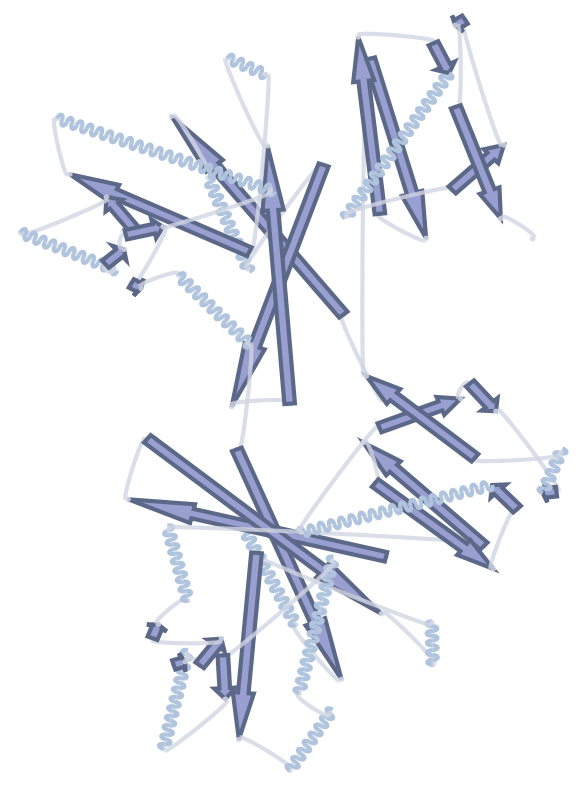

In [8]:
protein_config = portein.ProteinConfig(pdb_file="7lc2", rotate=True, height=10, output_prefix="images/7lc2")
ss = portein.SecondaryStructure(protein_config=protein_config, 
                                helix_config=portein.HelixConfig(), 
                                sheet_config=portein.SheetConfig(), 
                                turn_config=portein.TurnConfig())
ss.run()

Modify the figure e.g to highlight specific residues using the returned Axes object:

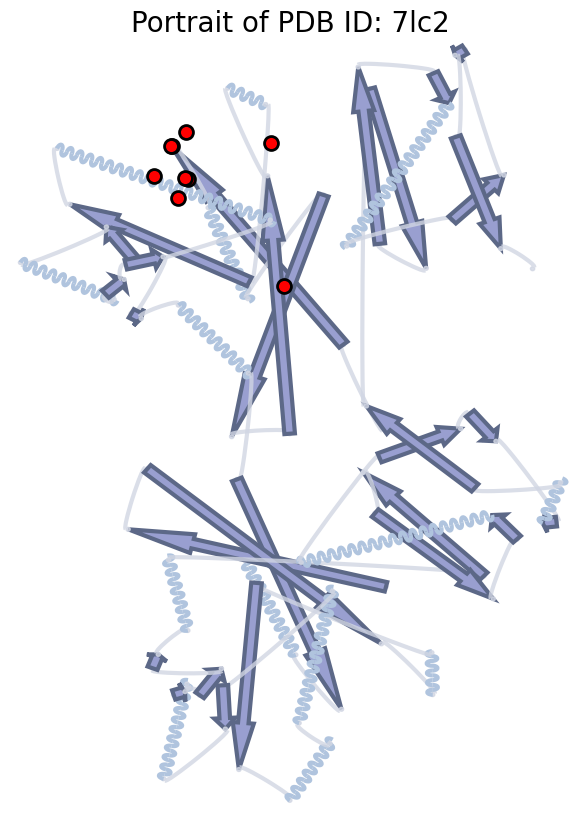

In [9]:
ax = ss.run()
ax.set_title("Portrait of PDB ID: 7lc2", fontsize=20)
highlight_residues = [30, 35, 25, 10, 11, 12, 13, 14, 15]
ax.scatter(ss.coords[highlight_residues, 0], 
           ss.coords[highlight_residues, 1],
           color="red", s=100, 
           edgecolor="black", linewidth=2)

Plot as a linear secondary structure diagram:

<Axes: >

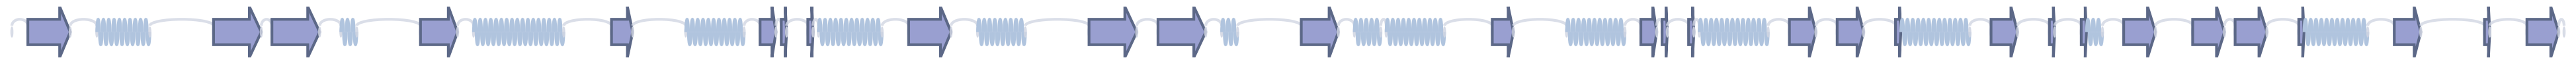

In [10]:
fig, ax = plt.subplots(1, figsize=(50, 1))
ss.run(ax=ax, linear=True)